In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
datadir = 'data/'

import warnings
warnings.filterwarnings('ignore')

def read_HSI():
    X = loadmat(datadir + 'PaviaU.mat')['paviaU']
    y = loadmat(datadir + 'PaviaU_gt.mat')['paviaU_gt']
    print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return X, y

X, y = read_HSI()

/home/makam0a/anaconda3/envs/prima/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


X shape: (610, 340, 103)
y shape: (610, 340)


In [2]:
import h5py
import os

def read_image(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]
        # Get the data
        data = list(f[a_group_key])
    return np.stack(data,axis=-1)

datadir = 'data/KAUST_SpectralReflectanceImages_h5/h5/'
files = os.listdir(datadir)
filename = "data/KAUST_SpectralReflectanceImages_h5/h5/" + np.random.choice(files)
wl = np.linspace(400,730,34)
data = read_image(filename)
images = []
for file in files[:300]:
    filename = datadir + file
    img = read_image(filename)
    images.append(img)
data = np.stack(images,axis=0)

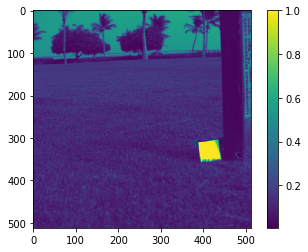

In [3]:
plt.imshow(data[2,:,:,10].T,vmax=1)
plt.colorbar()
plt.show()

In [4]:
shape = data.shape
pca = PCA(9)
transformed = pca.fit_transform(data.reshape(-1,shape[-1]))
transformed = transformed.reshape(*shape[:3],-1)
inversed=pca.inverse_transform(transformed)

In [5]:
import pickle
with open('/home/makam0a/Dropbox/projects/camera/data/pca_weights_0.pkl','wb') as file:
    pickle.dump(pca, file)
with open('/home/makam0a/Dropbox/projects/camera/data/pca_weights_0.pkl','rb') as file:
    pca_ = pickle.load(file)
pca_.n_components_

9

0.8225971360914432


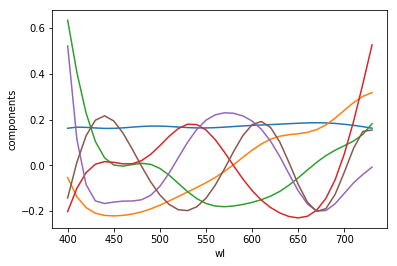

In [9]:
from sklearn.linear_model import LinearRegression, Lasso
from scipy.interpolate import interp1d

class FuncFitting():
    def __init__(self, wl, Y, nmodes=5, normalize=False, fitting='gaussian', fitting_params={}, regression=LinearRegression()):
        self.fitting_params=fitting_params
        if fitting=='sin':
            self.t_n=self.sin_n
        elif fitting=='poly':
            self.t_n=self.poly_n
        elif fitting == 'gaussian':
            self.t_n = self.gaussian
        elif fitting == 'lorenzian':
            self.t_n = self.lorenzian
        elif fitting == 'data':
            self.data = None
            self.t_n = self.from_data
        else:
            ValueError('Unrecognized function type!')
        self.wl = wl
        self.N = len(wl)
        self.nmodes = nmodes
        nsamples = Y.shape[0]
        X = np.zeros([self.N,nmodes])
        for i in range(nmodes):
            X[:,i] = self.t_n(i, **self.fitting_params)
        self.X = X
        self.y = Y.T
        self.model = regression
        self.model.fit(X,Y.T)
        self.score_ = self.model.score(X,Y.T)
        self.a = self.model.coef_
        self.fs = self.get_fs()
        
    def get_fs(self):
        fs=[]
        for coeff in self.a:
            res = np.zeros(len(self.wl))
            for j, k in enumerate(coeff):
                res += k * self.t_n(j,**self.fitting_params)
            f=interp1d(self.wl,res)
            fs.append(f)
        return fs
    
    def plot():
        pass
    
    def score(self,samples):
        y_pred = []
        y_true = []
        for sample in samples:
            RGB_true = sample.Y
            RGB_pred = self.spectra_to_XYZ(sample.spectra.wl, sample.X)
            y_pred.append(RGB_pred)
            y_true.append(RGB_true)
        y_true=np.array(y_true)
        y_pred = np.array(y_pred)
        return MSE(y_true,y_pred)

    def sin_n(self,n):
        x = np.arange(self.N)
        return 2 * np.sin(np.pi * (n + 1) * (x + 1) / (len(x) + 1)) / 2 / (self.N + 1)

    def poly_n(self,n):
        pass

    def spectra_to_XYZ(self):
        return self.fs(self.wl) + self.model.el.intercept_
    
    def gaussian(self,n,sigma=150):
        N = self.N + (self.N % self.nmodes)
        xi = np.arange(0,N,N/self.nmodes)[n]
        x = np.arange(self.N)
        return np.exp(-np.abs(x-xi)**2/sigma**2)

    def lorenzian(self,n,sigma=10):
        N = self.N + (self.N % self.nmodes)
        xi = np.arange(0,N,N/self.nmodes)[n]
        x = np.arange(self.N)
        y = (x-xi)/sigma/2
        return 1/(1+y**2)
    
    def from_data(self, n, arr, transform=(lambda x : x)):
        if self.data is None:
            self.data = arr
        f = transform(self.data[n])
        return f
        
    
X = pca.components_
regr = FuncFitting(wl,X,nmodes=9, fitting_params={'sigma':10}, regression=LinearRegression())
#regr = FuncFitting(wl,X,nmodes=9, fitting='data', fitting_params={'arr' : spectras}, regression=LinearRegression())
for i in range(6):
    plt.plot(wl, regr.get_fs()[i](wl)+regr.model.intercept_[i])
print(regr.score_)
plt.xlabel('wl')
plt.ylabel('components')
plt.show()

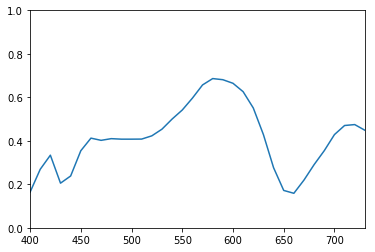

In [10]:
wl0, *exp = np.load('hyperdata/experiments.npy', allow_pickle=True)
mask = (wl0 > 300) & (wl0 < 800)
exp_spectras = np.zeros((len(exp),len(wl)))
for i in range(len(exp)):  
    exp_spectras[i] = interp1d(wl0[mask],exp[i][mask])(wl)
plt.plot(wl,exp_spectras[5])
plt.xlim(400,730)
plt.ylim(0,1)
plt.show()

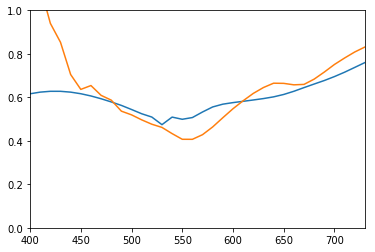

In [11]:
best_spectras = np.load('hyperdata/meta_spectra_new.npy', allow_pickle=True)
wl0 = best_spectras[0,:,0]*1e3
mask = (wl0 > 300) & (wl0 < 800)
best_spectras = best_spectras[:,:,1]
theor_spectras = np.zeros((len(exp),len(wl)))
for i in range(len(exp)):  
    theor_spectras[i] = interp1d(wl0[mask],best_spectras[i][mask])(wl)
plt.plot(wl, theor_spectras[0])
plt.plot(wl, exp_spectras[0])
plt.xlim(400,730)
plt.ylim(0,1)
plt.show()

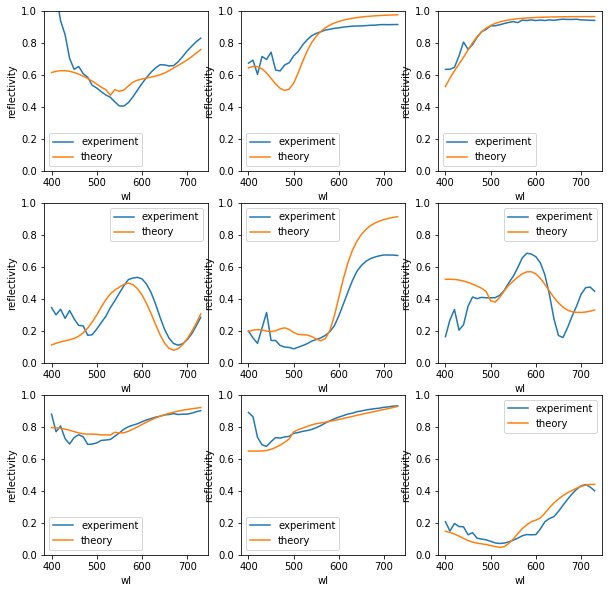

In [12]:
fit_components_ = np.zeros([9, 34])
plt.figure(figsize=[10,10])
for i in range(9):
    fit_components_[i] = regr.get_fs()[i](wl)+regr.model.intercept_[i]
    plt.subplot(3,3,i+1)
    plt.plot(wl,exp_spectras[i],label='experiment')
    plt.plot(wl,theor_spectras[i],label='theory')
    plt.legend()
    plt.ylim(0,1)
    plt.ylabel('reflectivity')
    plt.xlabel('wl')
plt.show()

In [66]:
from scipy.integrate import trapz
leff = np.zeros(9)
for i in range(9):
    leff[i] = trapz(exp_spectras[i], wl) / trapz(np.ones(len(wl)),wl)
print(leff.mean())
mask = (wl > 400) & (wl < 425)
trapz(np.ones(len(wl))[mask], wl[mask]) / trapz(np.ones(len(wl)),wl), 25/350

0.5789766595330454


(0.030303030303030304, 0.07142857142857142)

In [67]:
np.linspace(400,730,34)

array([400., 410., 420., 430., 440., 450., 460., 470., 480., 490., 500.,
       510., 520., 530., 540., 550., 560., 570., 580., 590., 600., 610.,
       620., 630., 640., 650., 660., 670., 680., 690., 700., 710., 720.,
       730.])

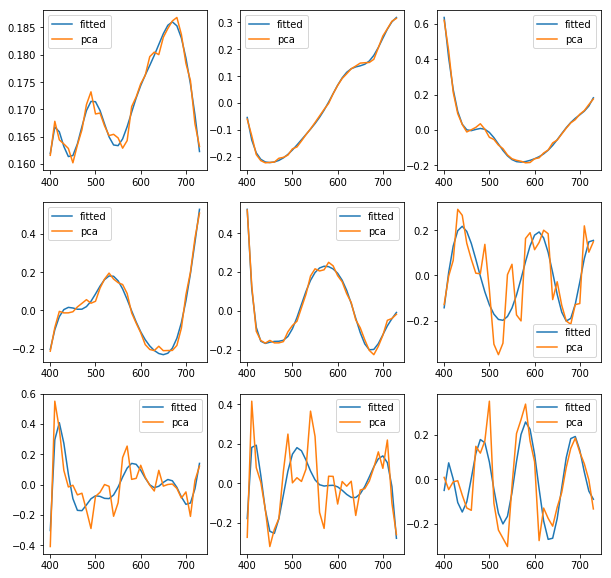

In [50]:
fit_components_ = np.zeros([9, 34])
plt.figure(figsize=[10,10])
for i in range(9):
    fit_components_[i] = regr.get_fs()[i](wl)+regr.model.intercept_[i]
    plt.subplot(3,3,i+1)
    plt.plot(wl,fit_components_[i],label='fitted')
    plt.plot(wl,pca.components_[i],label='pca')
    plt.legend()
plt.show()

In [51]:
regr_exp = FuncFitting(wl,X,nmodes=9, fitting='data', fitting_params={'arr' : exp_spectras}, regression=LinearRegression())
regr_theor = FuncFitting(wl,X,nmodes=9, fitting='data', fitting_params={'arr' : theor_spectras}, regression=LinearRegression())
print('experimental score = ', regr_exp.score_, 'theory score = ', regr_theor.score_)

experimental score =  0.6464702158760355 theory score =  0.7877654520961835


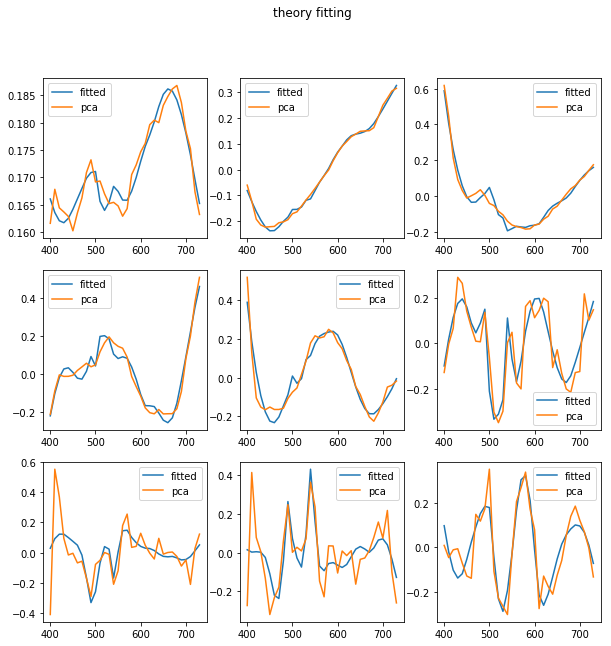

In [52]:
fit_components_theor = np.zeros([9, 34])
plt.figure(figsize=[10,10])
plt.suptitle('theory fitting')
for i in range(9):
    fit_components_theor[i] = regr_theor.get_fs()[i](wl)+regr_theor.model.intercept_[i]
    plt.subplot(3,3,i+1)
    plt.plot(wl,fit_components_theor[i],label='fitted')
    plt.plot(wl,pca.components_[i],label='pca')
    plt.legend()
plt.show()

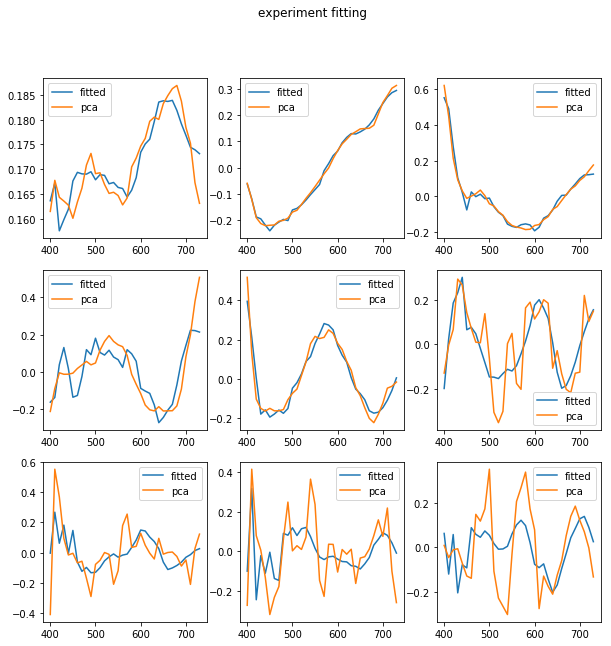

In [41]:
fit_components_exp = np.zeros([9, 34])
plt.figure(figsize=[10,10])
plt.suptitle('experiment fitting')
for i in range(9):
    fit_components_exp[i] = regr_exp.get_fs()[i](wl)+regr_exp.model.intercept_[i]
    plt.subplot(3,3,i+1)
    plt.plot(wl,fit_components_exp[i],label='fitted')
    plt.plot(wl,pca.components_[i],label='pca')
    plt.legend()
plt.show()

In [42]:
def reduce(data, filters):
    shape = data.shape
    data_ = data.reshape(*shape[:3],-1)
    return np.dot(data_ - pca.mean_, filters.T)

def inverse(data_reduced, filters, shape):
    print(data_reduced.shape)
    data_original = np.dot(data_reduced, filters) + pca.mean_
    return data_original.reshape(*shape)
    
def reduce_and_inverse(data, filters):
    shape = data.shape
    reduced = reduce(data, filters)
    inversed = inverse(reduced, filters, shape)
    return inversed

In [43]:
inversed_exp = reduce_and_inverse(data, fit_components_exp)
inversed_theor = reduce_and_inverse(data, fit_components_theor)

(300, 512, 512, 9)
(300, 512, 512, 9)


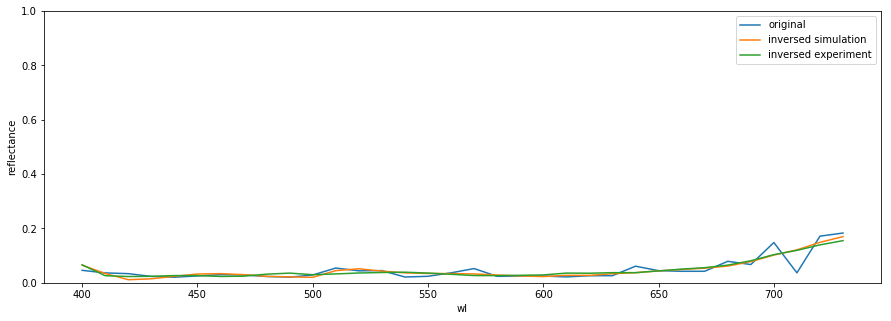

In [61]:
def plot_image(img, inversed, inversed_exp, axes=None):
    if axes is None:
        fig = plt.gcf()
        axes = fig.subplots(1,3)
    ax = axes[0]
    ax.imshow(img.T,cmap='gray')
    ax.set_axis_off()
    ax = axes[1]
    ax.imshow(inversed.T,cmap='gray')
    ax.set_axis_off()
    ax = axes[2]
    ax.imshow(np.abs(inversed_exp.T),cmap='gray')
    ax.set_axis_off()
    
def plot_spectra(sp1, sp2, sp3):
    plt.plot(wl, sp1, label='original')
    plt.plot(wl, sp2, label='inversed simulation')
    plt.plot(wl, sp3, label='inversed experiment')
    plt.ylim(0,1)
    plt.xlabel('wl')
    plt.ylabel('reflectance')
    plt.legend()

def plot_compare(img, inversed, inversed_exp, sample=0, band=None, spatial=None):
    if spatial is not None:
        mask = (sample, *spatial)
        plot_spectra(img[mask],inversed[mask], inversed_exp[mask])
    else:
        if band is None:
            plot_image(np.mean(img[sample,:,:],axis=-1), np.mean(inversed[sample,:,:],axis=-1), np.mean(inversed_exp[sample,:,:],axis=-1))
        else:
            plot_image(img[sample,:,:,band], inversed[sample,:,:,band], inversed_exp[sample,:,:,band])
spatial = np.random.randint(0,512,2)
sample = np.random.randint(200)
plt.figure(figsize=[15,5])
plot_compare(data, inversed_theor, inversed_exp, sample=sample,spatial=spatial)
plt.show()

In [56]:
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

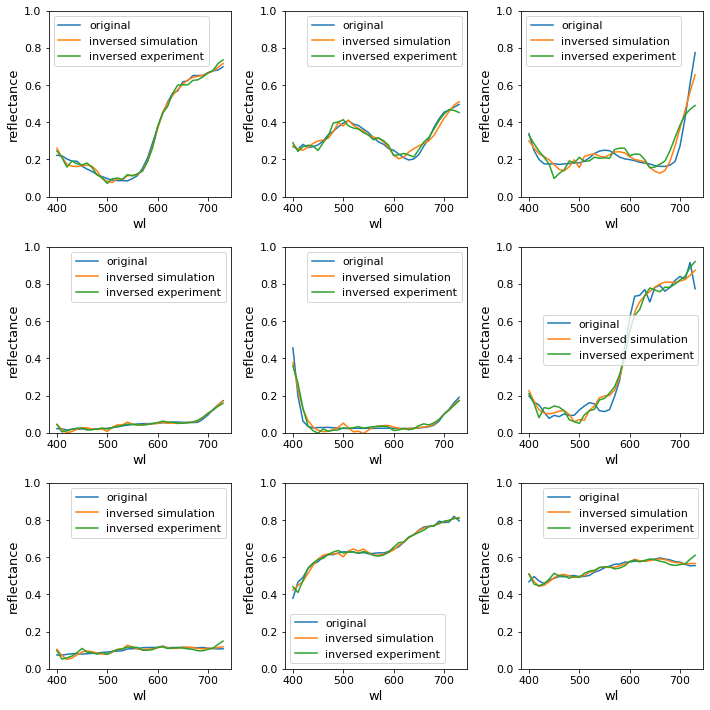

In [59]:
np.random.seed(11)
plt.figure(figsize=[10,10])
for i in range(9):
    fit_components_exp[i] = regr_exp.get_fs()[i](wl)+regr_exp.model.intercept_[i]
    plt.subplot(3,3,i+1)
    sample = np.random.randint(200)
    spatial = np.random.randint(0,512,2)
    plot_compare(data, inversed_theor, inversed_exp, sample=sample,spatial=spatial)
    plt.legend()
plt.tight_layout()
plt.savefig('figures/suppl/recovery_spectra.pdf', dpi=300, transparent=True)
plt.show()
plt.close()

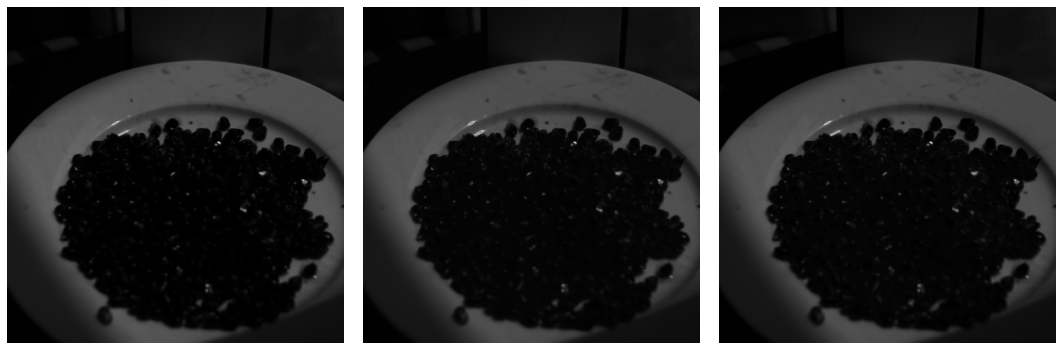

In [61]:
spatial = np.random.randint(0,512,2)
sample = np.random.randint(200)
plt.figure(figsize=[15,5])
plot_compare(data, inversed_theor, inversed_exp, sample=sample,band=10)
plt.tight_layout()
plt.show()

(3, 7)


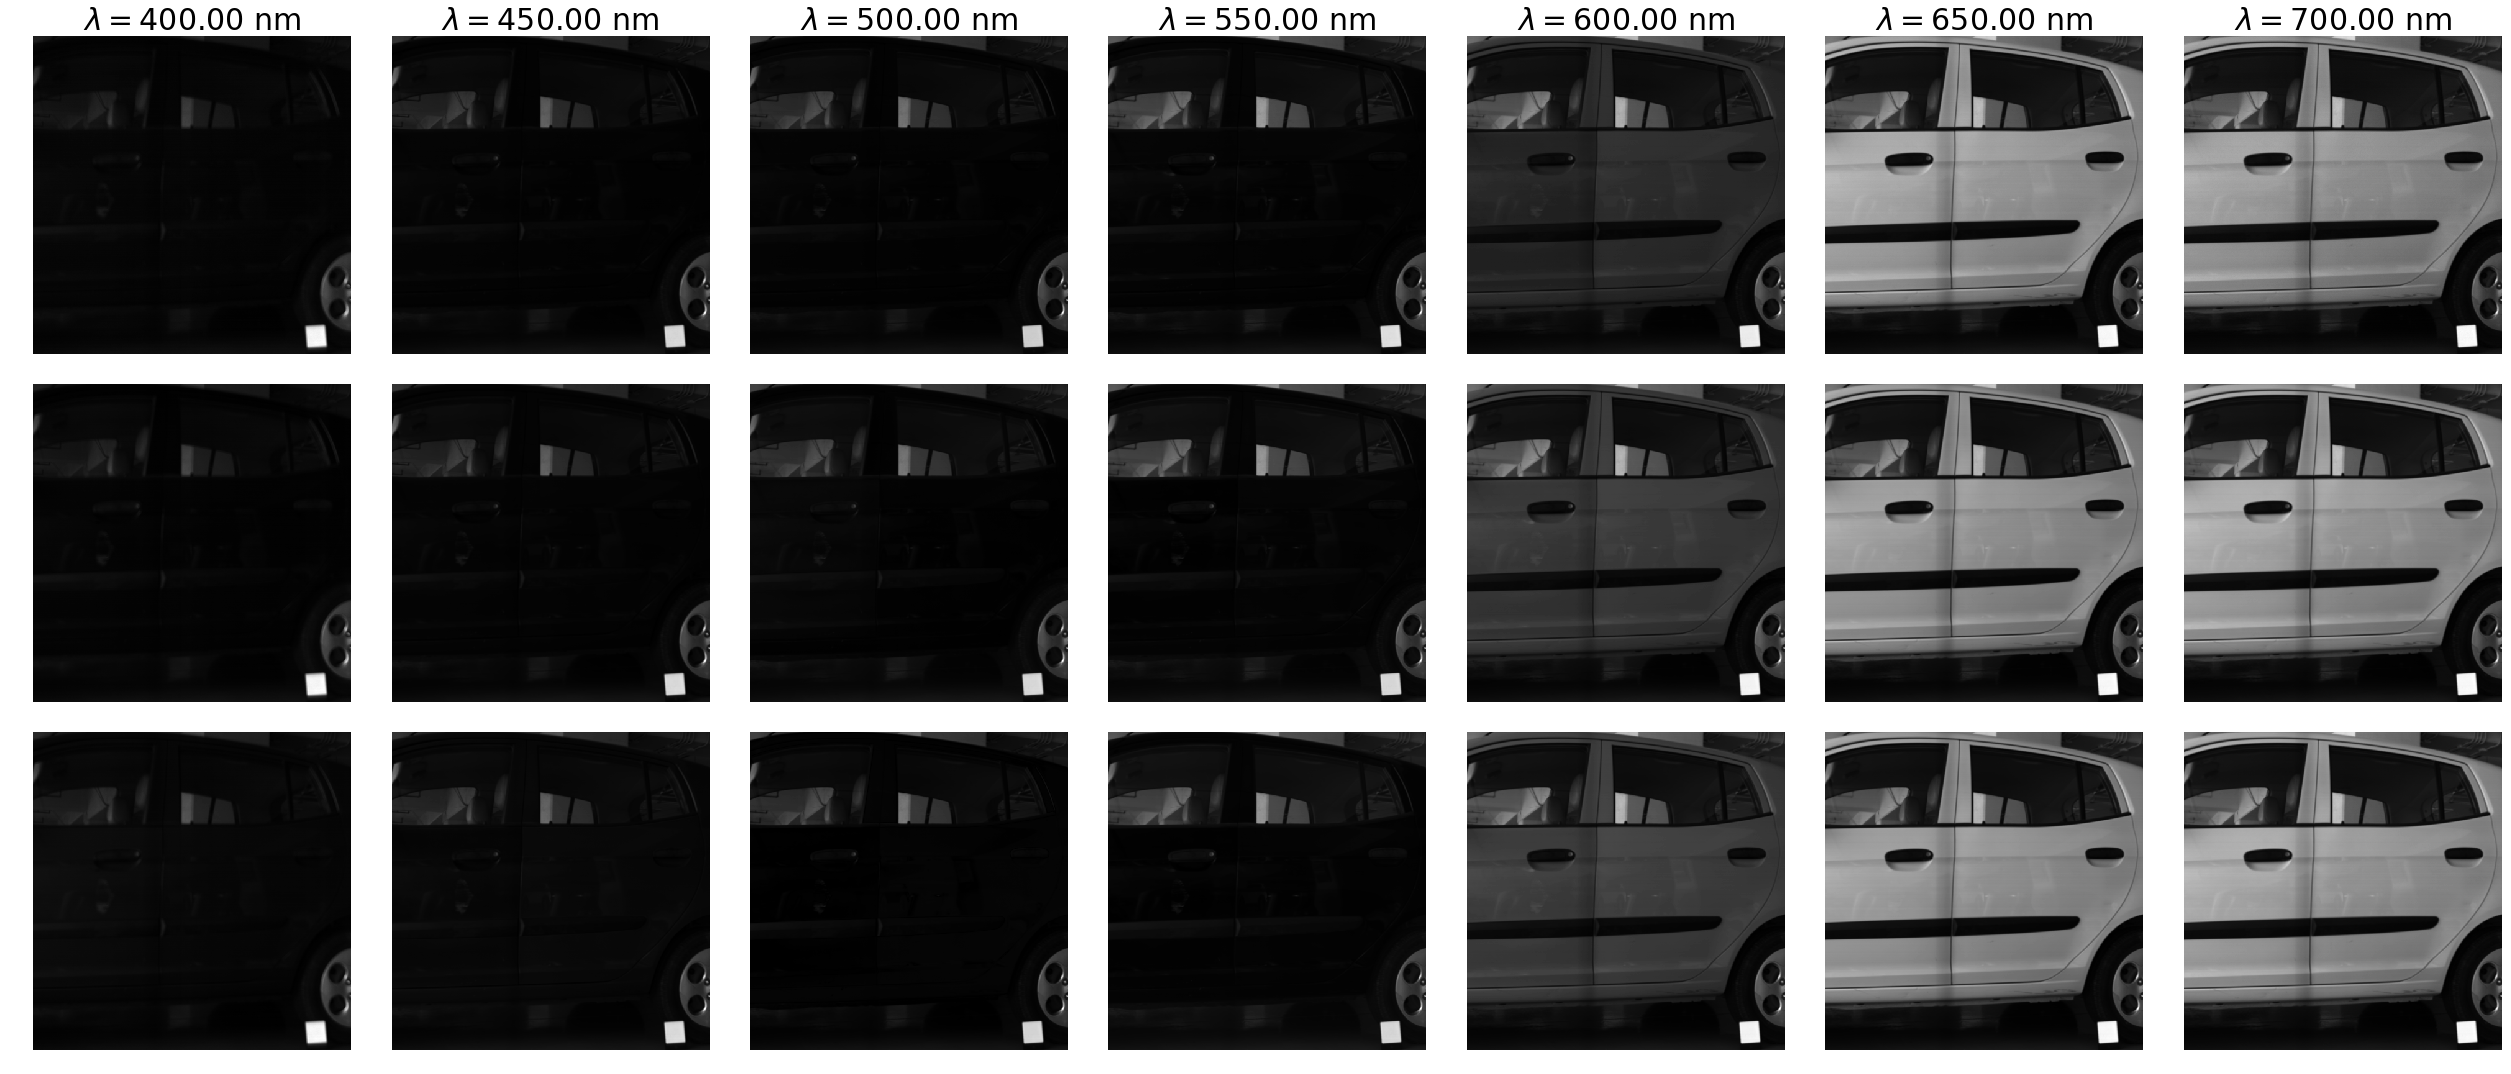

In [62]:
def plot_compare_images(img, inversed, inversed_exp, sample=0, bands = (0,)):
    n = len(bands)
    fig = plt.figure(figsize=(n*5,15))
    axes = fig.subplots(3,n)
    print(axes.shape)
    for i, ax in enumerate(axes.T):
        band = bands[i]
        ax[0].set_title('$\lambda=%.2f$ nm' % wl[band],fontsize=30)
        plot_image(img[sample,:,:,band], inversed[sample,:,:,band], inversed_exp[sample,:,:,band], axes=ax)
    plt.tight_layout()

sample = np.random.randint(200)
plot_compare_images(data, inversed_theor, inversed_exp, sample=sample,bands=np.arange(0,34,5))
plt.savefig('figures/suppl/reconstructed3.pdf', transparent=True, dpi=300)
plt.show()
plt.close()

In [63]:
reduced_exp = reduce(data, fit_components_exp)

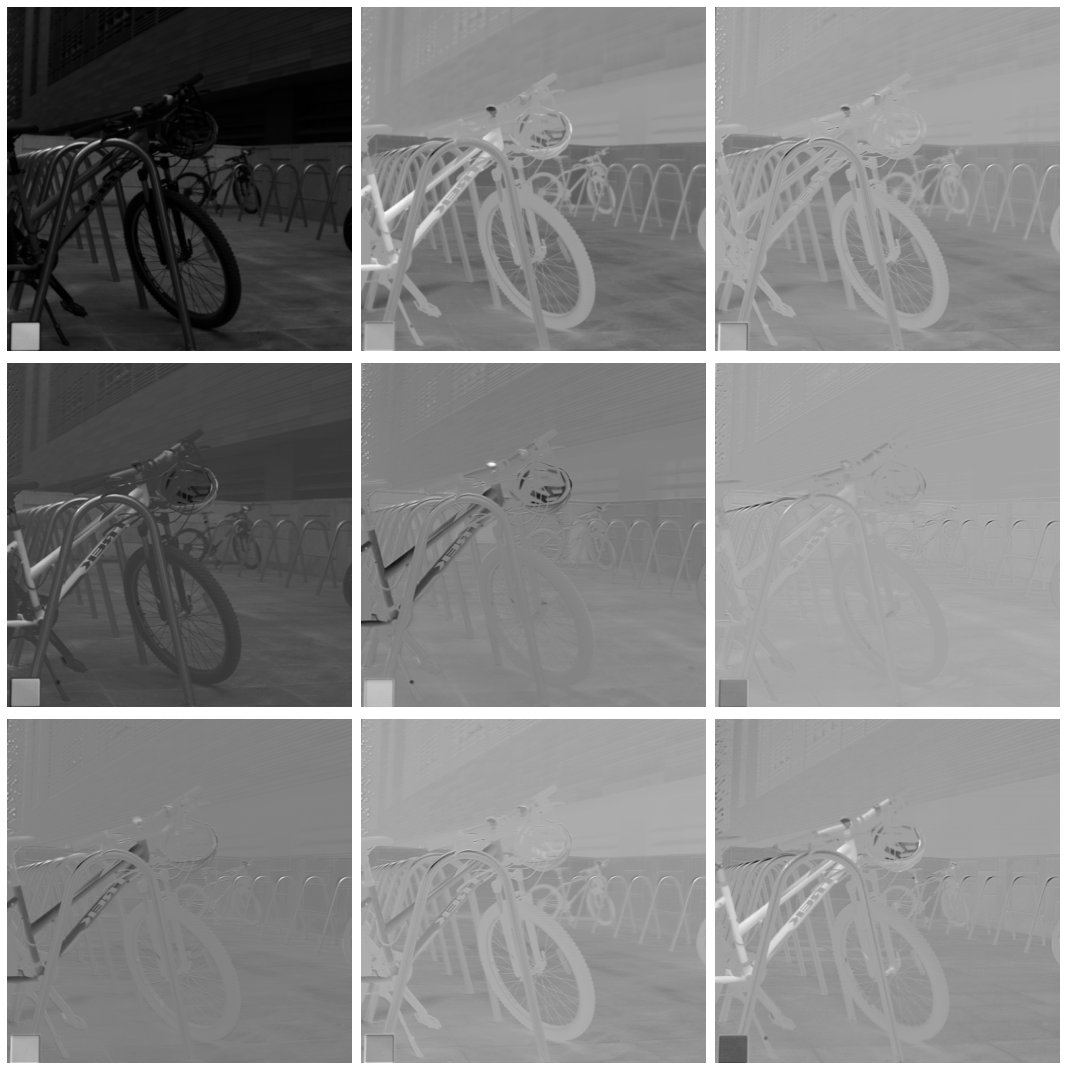

In [74]:
def plot_reduced(img, sample=0):
    fig = plt.figure(figsize=(15,15))
    axes = fig.subplots(3,3)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(img[sample,:,:,i].T,cmap='gray')
        ax.set_axis_off()
    plt.tight_layout()
        
plot_reduced(reduced_exp, sample=sample)
plt.savefig('figures/suppl/different_filters3.pdf', transparent=True, dpi=300)
plt.show()
plt.close()

In [57]:
from scipy.interpolate import interp1d
def read_image_fruit(filename, interpolate=True):
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]
        # Get the data
        data = list(f[a_group_key])
        data = np.stack(data,axis=-1)
        if interpolate:
            data = interp1d(wl_,data,axis=2)(wl)
    return data

SPECIM = '/home/makam0a/Dropbox/Primalight_shared/Current works/HOCULUS/SPECIM/'
datadir = '/home/makam0a/Dropbox/Primalight_shared/Current works/HOCULUS/Rebuttal/Converted/'
files = os.listdir(datadir)
filename = datadir + np.random.choice(files)
wl = np.linspace(400,730,34)
wl0 = 397.32
wl1 = 1003.58
wl_ = np.linspace(wl0,wl1,204)
mask = (wl_ < 750)
data2 = read_image_fruit(filename)
for file in files:
    filename = datadir + file
    img = read_image_fruit(filename)
    #np.save(SPECIM + 'training/visible/' + file[:-3] + '.npy', img)
data2 = np.stack(images,axis=0)

In [41]:
datadir = SPECIM + 'training/' + 'visible/'
files = os.listdir(datadir)
def read_numpy_fruit(filename):
    return np.load(filename)

wl = np.linspace(400,730,34)
images = []
for file in files:
    image = read_numpy_fruit(datadir+file)
    images.append(image)
data = np.stack(images, axis=0)

In [44]:
pca = PCA(9)
transformed = pca.fit_transform(data.reshape(-1,shape[-1]))
transformed = transformed.reshape(*shape[:3],-1)
inversed=pca.inverse_transform(transformed)

ValueError: cannot reshape array of size 747896832 into shape (200,512,512,newaxis)

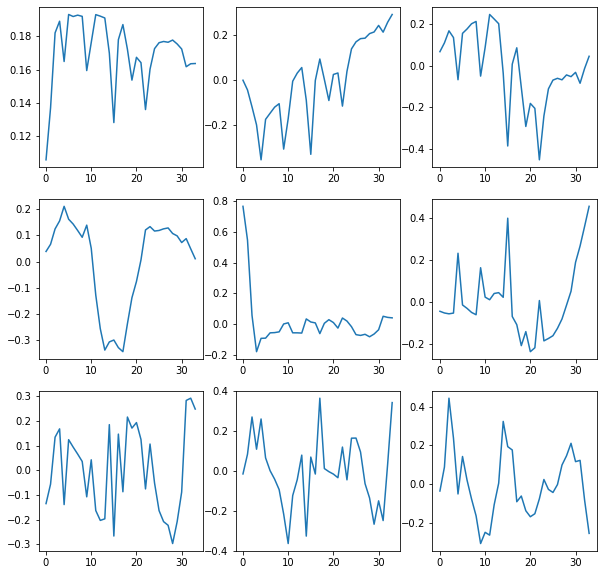

In [46]:
import pickle
with open('pca_fruit_weights.pkl','wb') as file:
    pickle.dump(pca, file)
with open('pca_fruit_weights.pkl','rb') as file:
    pca_ = pickle.load(file)
plt.figure(figsize=[10,10])
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(pca.components_[i])
plt.show()

In [58]:
inversed_exp = reduce_and_inverse(data2, fit_components_exp)
inversed_theor = reduce_and_inverse(data2, fit_components_theor)

(300, 512, 512, 9)
(300, 512, 512, 9)


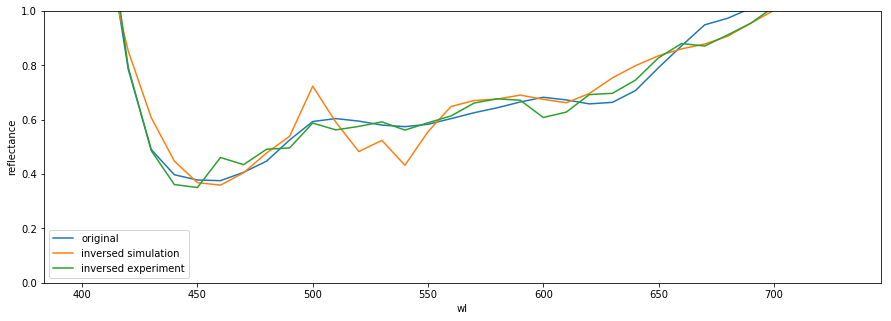

In [63]:
spatial = np.random.randint(0,512,2)
sample = np.random.randint(20)
plt.figure(figsize=[15,5])
plot_compare(data2, inversed_theor, inversed_exp, sample=sample,spatial=spatial)
plt.show()

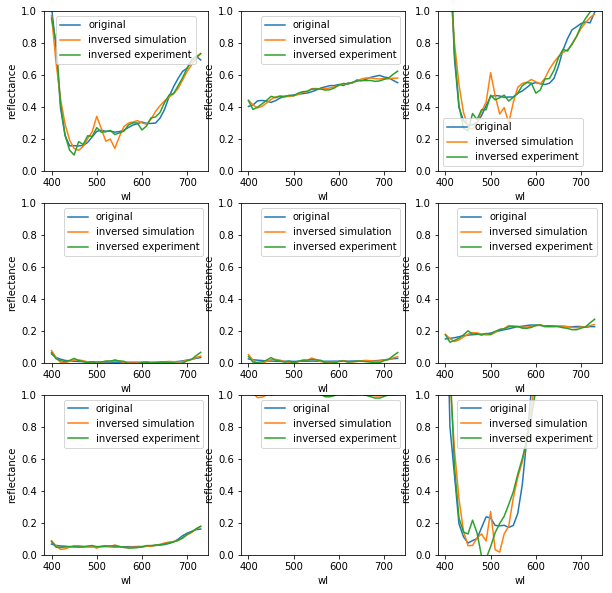

In [64]:
plt.figure(figsize=[10,10])
for i in range(9):
    fit_components_exp[i] = regr_exp.get_fs()[i](wl)+regr_exp.model.intercept_[i]
    plt.subplot(3,3,i+1)
    sample = np.random.randint(20)
    spatial = np.random.randint(0,512,2)
    plot_compare(data2, inversed_theor, inversed_exp, sample=sample,spatial=spatial)
    plt.legend()
plt.show()

(3, 12)


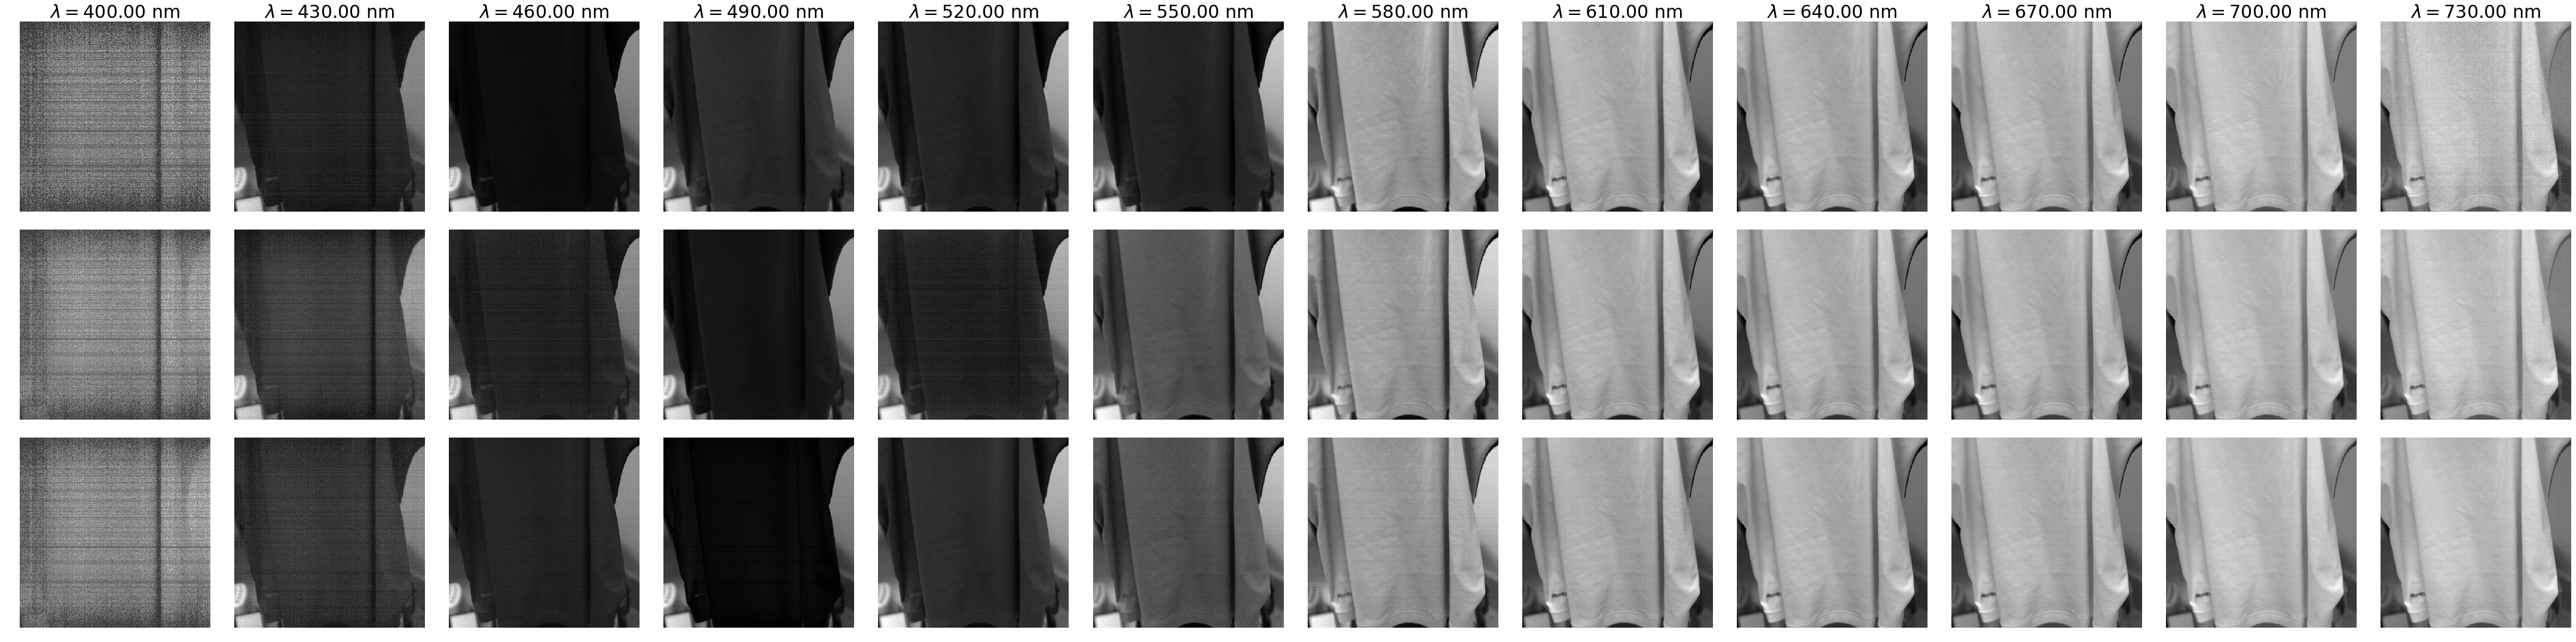

In [65]:
def plot_compare_images(img, inversed, inversed_exp, sample=0, bands = (0,)):
    n = len(bands)
    fig = plt.figure(figsize=(n*5,15))
    axes = fig.subplots(3,n)
    print(axes.shape)
    for i, ax in enumerate(axes.T):
        band = bands[i]
        ax[0].set_title('$\lambda=%.2f$ nm' % wl[band],fontsize=30)
        plot_image(img[sample,:,:,band], inversed[sample,:,:,band], inversed_exp[sample,:,:,band], axes=ax)
    plt.tight_layout()

plot_compare_images(data2, inversed_theor, inversed_exp, sample=sample,bands=np.arange(0,34,3))
plt.show()
plt.close()

In [309]:
reduced_exp = reduce(data2, fit_components_exp)

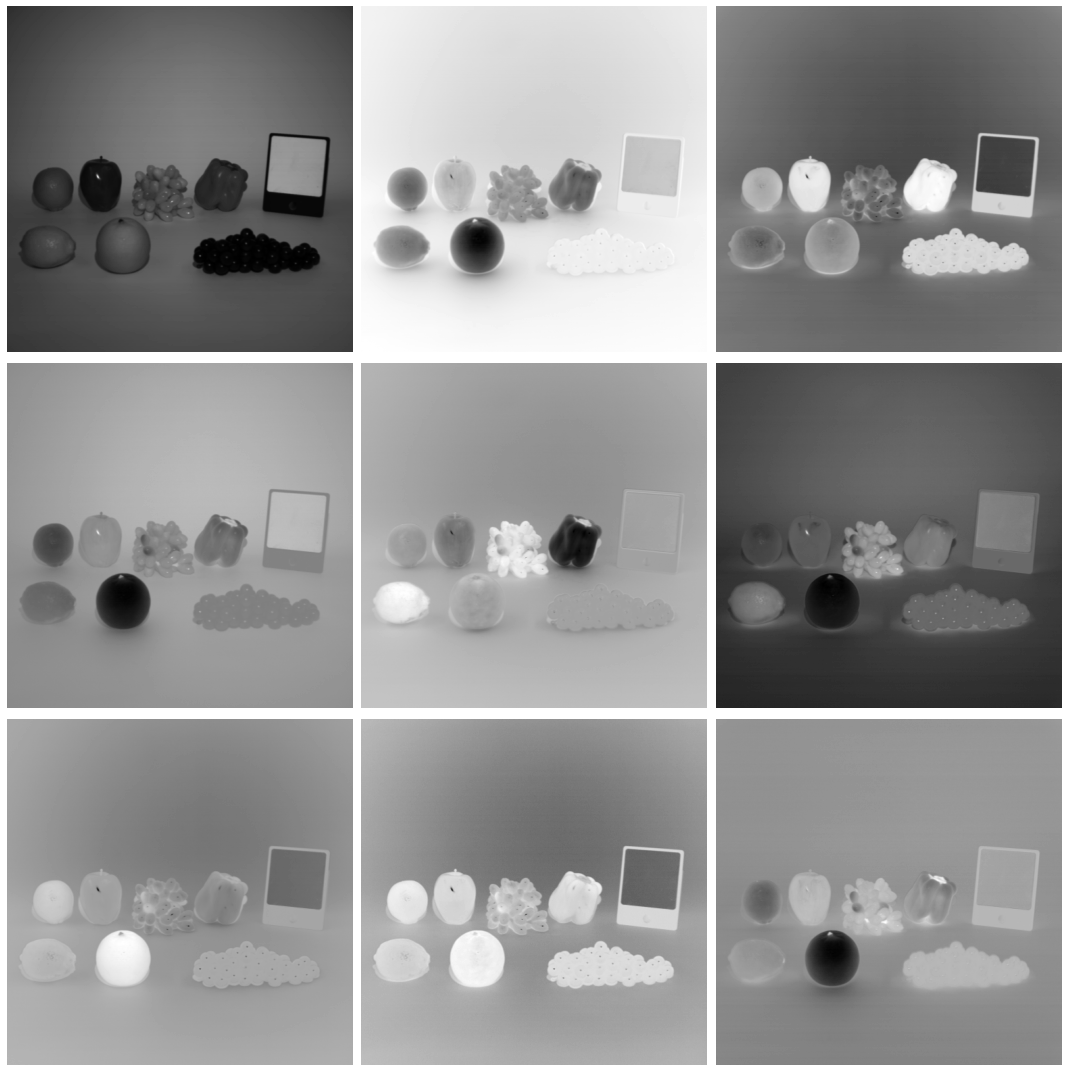

In [386]:
def plot_reduced(img, sample=0):
    fig = plt.figure(figsize=(15,15))
    axes = fig.subplots(3,3)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(img[sample,:,:,i].T,cmap='gray')
        ax.set_axis_off()
    plt.tight_layout()
        
plot_reduced(reduced_exp, sample=sample)
plt.show()

In [94]:
rmse_theor = np.sqrt(mean_squared_error(data.reshape((-1,34)), inversed.reshape((-1,34))))
rmse_exp = np.sqrt(mean_squared_error(data.reshape((-1,34)), inversed_exp.reshape((-1,34))))
print('theor RMSE = ', rmse_theor, '; exp RMSE = ', rmse_exp)

theor RMSE =  0.022497187835796944 ; exp RMSE =  0.04730641692410742


In [323]:
rmse_theor = np.sqrt(mean_squared_error(data2.reshape((-1,34)), inversed_theor.reshape((-1,34))))
rmse_exp = np.sqrt(mean_squared_error(data2.reshape((-1,34)), inversed_exp.reshape((-1,34))))
print('theor RMSE = ', rmse_theor, '; exp RMSE = ', rmse_exp)

theor RMSE =  0.051135759747152974 ; exp RMSE =  0.057410113739909105


In [ ]:
def plot_compare_images(img, inversed, inversed_exp, sample=0, bands = (0,)):
    n = len(bands)
    fig = plt.figure(figsize=(n*5,15))
    axes = fig.subplots(3,n)
    print(axes.shape)
    for i, ax in enumerate(axes.T):
        band = bands[i]
        ax[0].set_title('$\lambda=%.2f$ nm' % wl[band],fontsize=30)
        plot_image(img[sample,:,:,band], inversed[sample,:,:,band], inversed_exp[sample,:,:,band], axes=ax)
    plt.tight_layout()